# Lab 6

Integrantes:

- Manuel Achila 161250
- Juan Avila 20090
- Diego Franco 20240

## Ejercicio 1

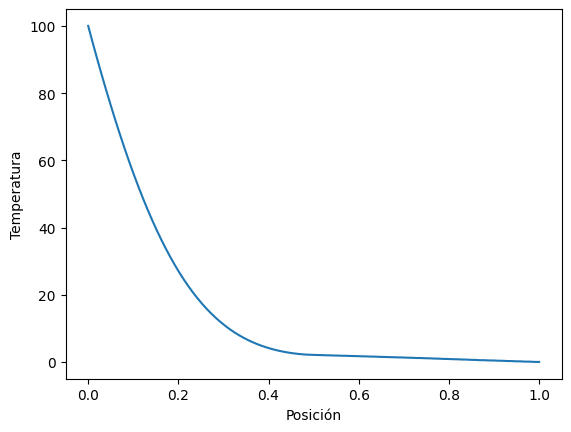

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos constantes
L = 1.0  # longitud de la varilla
dx = 0.01  # paso espacial
dt = 0.005  # paso temporal
n_steps = 100  # número de pasos de tiempo
alpha1 = 0.01  # conductividad térmica material 1
alpha2 = 0.02  # conductividad térmica material 2
division = int(L/2/dx)  # punto donde cambia el material

def macroscopic_temperature(u0, alpha1, alpha2):
    u = np.copy(u0)
    for j in range(1, len(u) - 1):
        if j < division:
            u[j] = u[j] + alpha1 * dt / dx**2 * (u[j + 1] - 2 * u[j] + u[j - 1])
        else:
            u[j] = u[j] + alpha2 * dt / dx**2 * (u[j + 1] - 2 * u[j] + u[j - 1])
    return u

def microscopic_temperature(u0, boundary_conditions):
    u = np.copy(u0)
    random_variation = 1 + 0.05 * np.random.randn(len(u))  # Variación aleatoria para inhomogeneidades
    for j in range(1, len(u) - 1):
        local_variation = random_variation[j]
        gradient = 0.01 * (u[j+1] - u[j-1])  # Gradiente de temperatura local
        if j < division:
            u[j] = u[j] + local_variation * alpha1 * dt / dx**2 * (u[j + 1] - 2 * u[j] + u[j - 1]) + gradient
        else:
            u[j] = u[j] + local_variation * alpha2 * dt / dx**2 * (u[j + 1] - 2 * u[j] + u[j - 1]) + gradient
    u[0], u[-1] = boundary_conditions
    return u


def multi_scale_temperature(u0, steps):
    for _ in range(steps):
        u_macro = macroscopic_temperature(u0, alpha1, alpha2)
        boundary_conditions = (u_macro[0], u_macro[-1])
        u0 = microscopic_temperature(u_macro, boundary_conditions)
    return u0

# Condición inicial
u0 = np.zeros(int(L/dx))
u0[0] = 100  # temperatura en un extremo

u_final = multi_scale_temperature(u0, n_steps)

# Visualización
plt.plot(np.linspace(0, L, int(L/dx)), u_final)
plt.xlabel("Posición")
plt.ylabel("Temperatura")
plt.show()


## Preguntas

**a. ¿En qué se diferencia el modelo macroscópico del modelo microscópico en este escenario?**

El modelo macroscópico describe la distribución de temperatura a lo largo de la varilla considerando solamente las propiedades promedio del material y las condiciones de contorno. No considera inhomogeneidades a nivel microscópico o variaciones locales en la conductividad. En contraste, el modelo microscópico ahora considera inhomogeneidades aleatorias en la conductividad térmica y gradientes de temperatura locales que pueden surgir debido a características microscópicas, como impurezas o microestructuras.

**b. ¿Cuáles son las condiciones de contorno del modelo microscópico y cómo las determina el modelo macroscópico?**

Las condiciones de contorno para el modelo microscópico son las temperaturas en los extremos de la varilla. Estas condiciones de contorno son proporcionadas por el modelo macroscópico, que las calcula como parte de su simulación.

**c. ¿Cómo adaptaría este modelo multiescala si la varilla estuviera compuesta por más de dos materiales diferentes?**

Si la varilla estuviera compuesta por más de dos materiales, se necesitarían constantes adicionales de conductividad térmica y las funciones se adaptarían para manejar múltiples segmentos con diferentes propiedades. Se debería establecer un punto de división para cada cambio de material y usar las conductividades térmicas correspondientes. Las inhomogeneidades y gradientes de temperatura a nivel microscópico también podrían variar para cada material, requiriendo adaptaciones específicas en el modelo microscópico para cada segmento.

## Ejercicio 2

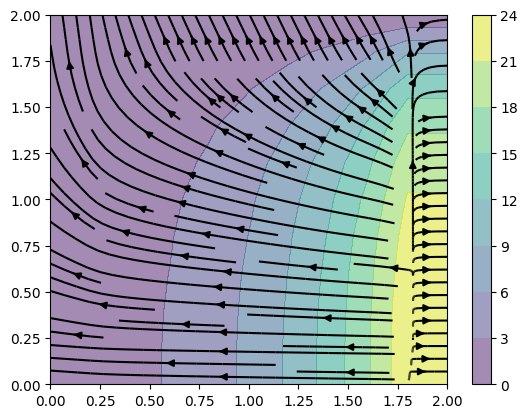

In [21]:
def flujo_darcy(permeabilidad, delta_p, viscosidad):
    velocidad = -permeabilidad * delta_p / viscosidad
    return velocidad

def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for _ in range(50):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        # Condiciones de frontera para p
        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
        
    return p

def naiver_stoke(nx, ny, nt, dt, rho, nu, q):

    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    X, Y = np.meshgrid(x, y)


    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))

# Loop de tiempo
    u[:, -1] = q
    for _ in range(nt):
        un = u.copy()
        vn = v.copy()

        b = build_up_b(rho, dt, dx, dy, u, v)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 * 
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 1
        u[-1, :] = 0
        v[0, :]  = 0
        v[-1, :]=0
        v[:, 0]  = 0
        v[:, -1] = 0

        return X, Y, u, v, p

def multi_escala_concurrente(k, grad_p, mu, nx, ny, nt, rho, nu, dt):
    q = flujo_darcy(k, grad_p, mu)
    X, Y, u, v, p = naiver_stoke(nx, ny, nt, dt, rho, nu, q)

    # Visualización
    fig, ax = plt.subplots()
    cf = ax.contourf(X, Y, p, alpha=0.5)
    fig.colorbar(cf, ax=ax)
    plt.streamplot(X, Y, u, v, color='k')
    plt.show()


multi_escala_concurrente(1, 10, 15, 11, 11, 100, 1, 0.1, 0.01)

a. ¿En qué se diferencia el enfoque multiescala concurrente del enfoque multiescala secuencial?
- El enfoque multiescala concurrente la simulaciones a nivel microscopico y macroscopico se ejecutan simultáneamente y se comunican entre sí durante la simulación. Por el contrario, en el enfoque secuencial, se ejecuta primero una simulación macroscopica y luego, basándose en sus resultados, se ejecuta microscopica.

b. ¿Qué información del modelo macroscópico se pasa al modelo microscópico y cómo afecta a la simulación microscópica?
- En el esquema propuesto, la velocidad calculada por la ley de Darcy en el modelo macroscópico se pasa al modelo microscópico como una condición de frontera o inicial. Esta tasa de flujo influiría en las velocidades y patrones de flujo en el modelo microscópico, proporcionando una conexión entre las escalas.

c. ¿Cuáles son las ventajas de utilizar modelado multiescala concurrente en este escenario?
- Ventajas:

    - Mayor precisión: Al tener en cuenta la información de ambas escalas simultáneamente, se puede obtener una simulación más pprecisa del comportamiento del fluido incluyendo varios factores.

    - Adaptabilidad: El modelo macroscópico puede adaptarse a las condiciones cambiantes del modelo microscópico y viceversa, debido a que considera muchos de los factores que influyen en el comportamiento del fluido.

    - Complejidad capturada: Ambas partes, microscópica y macroscópica, pueden capturar la complejidad del sistema ya que comparten la información entre sí permitiendo que se adapten a las condiciones cambiantes.

# Ejercicio 3

In [22]:
import random

class Individuo:
    
    def __init__(self, prob_reproduccion_base=0.10, prob_mortalidad_base=0.05, prob_migracion_base=0.01):
        self.prob_reproduccion_base = prob_reproduccion_base
        self.prob_mortalidad_base = prob_mortalidad_base
        self.prob_migracion_base = 0.01
        
    def reproducirse(self, factor_ambiental=0.6):
        if random.random() < self.prob_reproduccion_base * factor_ambiental:
            return True
        return False
    
    def morir(self, factor_ambiental=1.0):
        if random.random() < self.prob_mortalidad_base * factor_ambiental:
            return True
        return False

    def migrar(self, factor_ambiental=0.5):
        if random.random() < self.prob_migracion_base * factor_ambiental:
            return True
        return False
    
class Comunidad:
    
    def __init__(self, num_individuos_iniciales=100, factor_ambiental=1.0):
        self.individuos = [Individuo() for _ in range(num_individuos_iniciales)]
        self.factor_ambiental = factor_ambiental
    
    def paso_anual(self):
        nuevos_individuos = []
        individuos_a_eliminar = []
        
        # Determinar reproducciones y muertes
        for individuo in self.individuos:
            if individuo.reproducirse(self.factor_ambiental):
                nuevos_individuos.append(Individuo())
            if individuo.morir(self.factor_ambiental):
                individuos_a_eliminar.append(individuo)
        
        # Añadir nuevos individuos y eliminar los que murieron
        self.individuos.extend(nuevos_individuos)
        for individuo in individuos_a_eliminar:
            self.individuos.remove(individuo)
    
    def poblacion_actual(self):
        return len(self.individuos)

    def agregar_individuo(self, individuo):
        self.individuos.append(individuo)
    
    def eliminar_individuo(self, individuo):
        self.individuos.remove(individuo)


class Mundo:
    
    def __init__(self, num_comunidades=10, individuos_por_comunidad=100, prob_desastre=0.08):
        self.comunidades = [Comunidad(num_individuos_iniciales=individuos_por_comunidad) for _ in range(num_comunidades)]
        self.prob_desastre = prob_desastre
        self.desastres = 0
    
    def paso_anual(self):
        # Simula un año para cada comunidad
        for comunidad in self.comunidades:
            comunidad.paso_anual()

            # Simula la migración de individuos
            for individuo in comunidad.individuos:
                if individuo.migrar():
                    comunidad.eliminar_individuo(individuo)
                    nueva_comunidad = random.choice(self.comunidades)
                    nueva_comunidad.agregar_individuo(individuo)
        
        # Verifica si ocurre un desastre natural
        if random.random() < self.prob_desastre:
            self.desastres += 1
            for comunidad in self.comunidades:
                individuos_a_eliminar = random.sample(comunidad.individuos, int(0.10 * comunidad.poblacion_actual()))
                for individuo in individuos_a_eliminar:
                    comunidad.individuos.remove(individuo)
    
    def poblacion_total(self):
        return sum([comunidad.poblacion_actual() for comunidad in self.comunidades])

# Probamos la clase Mundo
print('Poblacion inicial: ', 10*100)
print('Comunidades (100 individuos por comunidad): ', 10)

mundo = Mundo(num_comunidades=10, individuos_por_comunidad=100)
for _ in range(10):  # Simulamos 10 años
    mundo.paso_anual()


print('Poblacion final: ', mundo.poblacion_total())
for i, comunidad in enumerate(mundo.comunidades):
    print('Comunidad {}: {}'.format(i, comunidad.poblacion_actual()))

print('Desastres: ', mundo.desastres)

Poblacion inicial:  1000
Comunidades (100 individuos por comunidad):  10
Poblacion final:  1517
Comunidad 0: 168
Comunidad 1: 127
Comunidad 2: 154
Comunidad 3: 138
Comunidad 4: 130
Comunidad 5: 167
Comunidad 6: 156
Comunidad 7: 167
Comunidad 8: 156
Comunidad 9: 154
Desastres:  1


## Preguntas

**a. ¿Qué es el modelado multiescala y por qué es esencial para comprender sistemas complejos como el crecimiento de la población?**

Es una forma de representar y modelar un sistema mucho más complejo ya que permite definir varias escalas, desde un nivel muy pequeño como los individuos hasta uno más grande como el mundo en este caso o la población global. Es muy importante ya que permite modelar el comportamiento y desiciones de los individuos y como estos afectan a la población en general, así como el comportamiento de comunidades y como estas afectan a la población global.

**b. Describe el modelo a nivel individual en esta simulación multiescala. ¿Qué factores se consideran a escala individual?**

Se tomará en cuenta la probabilidad de reproducirse dependiendo del ambiente en el que se encuentra y de la mortalidad de los individuos. Por último tambien se tomará en cuenta la probabilidad de migrar a otro ambiente.

**c. Discuta el modelo a escala de comunidad local. ¿Cómo incorpora interacciones entre individuos y factores ambientales?**

Este modelo a nivel de comunidad simula un año recorriendo los individuos y viendo las decisiones que toman, alterando el tamaño de la población dependiendo de la mortalidad y de la reproducción de los habitantes.

**d. Explique el modelo a escala global. ¿Qué parámetros y factores se consideran al modelar toda la población mundial?**

Se simula el paso de tiempo en las comunidades y también se agrega la probabilidad de un desastre natural que reduce la población de una comunidad. También se toma en cuenta la migración de individuos entre comunidades.

## Pregunta 4

Número de vehículos:  300
Número de vehículos en el segmento 1:  150
Número de vehículos en el segmento 2:  150
2


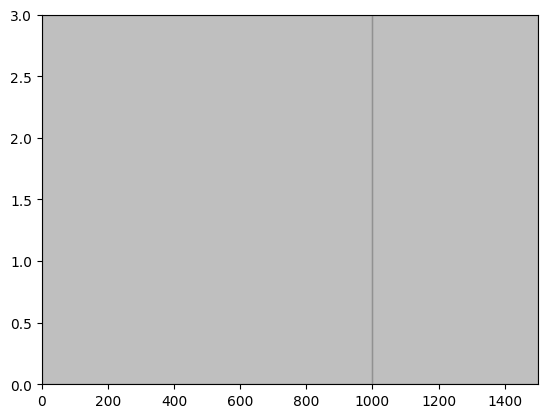

In [23]:
import random

class Vehiculo:

    def __init__(self, id, velocidad_deseada, distancia_al_vehiculo_que_le_precede, condiciones_carretera, tiempo_de_reaccion=1.0, dt=1.0):
        self.id = id
        self.velocidad_deseada = velocidad_deseada
        self.distancia_al_vehiculo_que_le_precede = distancia_al_vehiculo_que_le_precede
        self.condiciones_carretera = condiciones_carretera
        self.velocidad = 0
        self.aceleracion = 0
        self.tiempo_de_reaccion = tiempo_de_reaccion
        self.dt = dt
        self.posicion = 0

    def actualizar_velocidad(self):
        velocidad_actual = self.velocidad_deseada - self.aceleracion * self.dt

        if velocidad_actual > 0:
            velocidad_actual = min(velocidad_actual, self.distancia_al_vehiculo_que_le_precede / self.tiempo_de_reaccion)
        else:
            velocidad_actual = max(velocidad_actual, 0)

        self.posicion += velocidad_actual * self.dt
        self.velocidad = velocidad_actual
        self.aceleracion = (self.velocidad_deseada - self.velocidad) / self.dt

        return velocidad_actual


class SegmentoDeCarretera:

    def __init__(self, longitud, ancho, limite_velocidad, dt=1.0, capacidad=100):
        self.longitud = longitud
        self.ancho = ancho
        self.limite_velocidad = limite_velocidad
        self.vehiculos = []
        self.dt = dt
        self.capacidad = capacidad  # Capacidad máxima de vehículos en el segmento
        self.densidad_de_trafico = 0  # Inicialmente no hay tráfico

    def calcular_flujo(self, densidad_de_trafico):
        velocidad_media = self.limite_velocidad * (1 - densidad_de_trafico / self.capacidad)
        flujo = velocidad_media * densidad_de_trafico
        return flujo
    
    def agregar_vehiculo(self, vehiculo):
        if vehiculo.velocidad > self.limite_velocidad:
            vehiculo.velocidad = self.limite_velocidad
        self.vehiculos.append(vehiculo)
        return vehiculo


class Interseccion:

    def __init__(self, tiempos_de_luz, geometria_de_interseccion, comportamiento_de_conductores):
        self.tiempos_de_luz = tiempos_de_luz
        self.geometria_de_interseccion = geometria_de_interseccion
        self.comportamiento_de_conductores = comportamiento_de_conductores

    def simular(self, flujo_de_entrada):
        flujo_de_salida = self.calcular_flujo_de_salida(flujo_de_entrada)
        self.actualizar_estado(flujo_de_salida)
        return flujo_de_salida

    def calcular_flujo_de_salida(self, flujo_de_entrada):
        flujo_de_salida = 0
        for vehiculo in flujo_de_entrada:
            if self.puede_pasar_interseccion(vehiculo):
                flujo_de_salida += 1
        return flujo_de_salida

    def puede_pasar_interseccion(self, vehiculo):
        # Para simplificar, suponemos que todos los vehículos pueden pasar
        return True

    def actualizar_estado(self, flujo_de_salida):
        # Para simplificar, no hacemos nada en esta implementación
        pass

# # Crea los vehículos
# vehiculo_1 = Vehiculo(id=1, velocidad_deseada=100, distancia_al_vehiculo_que_le_precede=10, condiciones_carretera="buenas")
# vehiculo_2 = Vehiculo(id=2, velocidad_deseada=100, distancia_al_vehiculo_que_le_precede=20, condiciones_carretera="buenas")
vehiculos = []
distancia = 10
for i in range(300):
    velocidad = random.randint(80, 120)
    vehiculos.append(Vehiculo(id=i, velocidad_deseada=velocidad, distancia_al_vehiculo_que_le_precede=distancia, condiciones_carretera="buenas"))
    distancia += 10

print("Número de vehículos: ", len(vehiculos))

# Crea los segmentos de carretera
segmento_1 = SegmentoDeCarretera(1000, 3, 60)
segmento_2 = SegmentoDeCarretera(500, 3, 60)

# Crea la intersección
interseccion = Interseccion({
    "norte-sur": {"rojo": 10, "verde": 20},
    "este-oeste": {"rojo": 20, "verde": 10}
},
geometria_de_interseccion={
    "forma": "rectangular",
    "longitud": 100,
    "ancho": 50
},
comportamiento_de_conductores={
    "agresividad": 0.5,
    "obediencia": 0.8
})

# Agrega los vehículos a los segmentos de carretera
# segmento_1.agregar_vehiculo(vehiculo_1)
# segmento_2.agregar_vehiculo(vehiculo_2)
vehiculos_segmento_1 = []
vehiculos_segmento_2 = []
total = len(vehiculos)
for vehiculo in vehiculos:
    if total%2 == 0:
        vehiculos_segmento_1.append(vehiculo)
    else:
        vehiculos_segmento_2.append(vehiculo)
    total -= 1

segmento_1.vehiculos = vehiculos_segmento_1
segmento_2.vehiculos = vehiculos_segmento_2

print("Número de vehículos en el segmento 1: ", len(segmento_1.vehiculos))
print("Número de vehículos en el segmento 2: ", len(segmento_2.vehiculos))

# Simula el flujo de tráfico
for _ in range(100):
    for vehiculo in segmento_1.vehiculos:
        vehiculo.actualizar_velocidad()
        vehiculo.posicion += vehiculo.velocidad * segmento_1.dt
    
    for vehiculo in segmento_2.vehiculos:
        vehiculo.actualizar_velocidad()
        vehiculo.posicion += vehiculo.velocidad * segmento_2.dt


    flujo_segmento_1 = segmento_1.calcular_flujo(segmento_1.densidad_de_trafico)
    flujo_segmento_2 = segmento_2.calcular_flujo(segmento_2.densidad_de_trafico)

    flujo_interseccion = interseccion.simular([flujo_segmento_1, flujo_segmento_2])

    segmento_1.densidad_de_trafico = (segmento_1.densidad_de_trafico + flujo_segmento_1 - flujo_interseccion) / segmento_1.longitud
    segmento_2.densidad_de_trafico = (segmento_2.densidad_de_trafico + flujo_segmento_2 - flujo_interseccion) / segmento_2.longitud

# Resultado del flujo de tráfico en la intersección
print(flujo_interseccion)

# Visualización
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.set_xlim(0, segmento_1.longitud + segmento_2.longitud)
ax.set_ylim(0, max(segmento_1.ancho, segmento_2.ancho))

# Segmento 1
rect = patches.Rectangle((0, 0), segmento_1.longitud, segmento_1.ancho, color='grey', alpha=0.5)
ax.add_patch(rect)

# Segmento 2
rect = patches.Rectangle((segmento_1.longitud, 0), segmento_2.longitud, segmento_2.ancho, color='grey', alpha=0.5)
ax.add_patch(rect)

# Vehículos
for vehiculo in segmento_1.vehiculos:
    rect = patches.Rectangle((vehiculo.posicion, 0), 5, segmento_1.ancho, color='blue', alpha=0.5)
    ax.add_patch(rect)

for vehiculo in segmento_2.vehiculos:
    rect = patches.Rectangle((segmento_1.longitud + vehiculo.posicion, 0), 5, segmento_2.ancho, color='blue', alpha=0.5)
    ax.add_patch(rect)

plt.show()


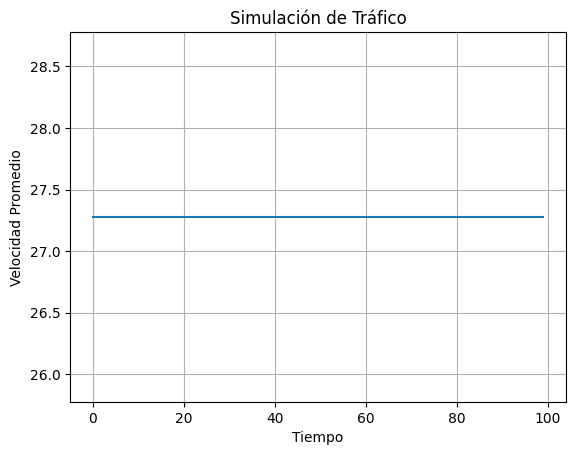

In [24]:
class Vehiculo:

    def __init__(self, id, velocidad_deseada, distancia_al_vehiculo_que_le_precede, condiciones_carretera, tiempo_de_reaccion=1.0, dt=1.0):
        self.id = id
        self.velocidad_deseada = velocidad_deseada
        self.distancia_al_vehiculo_que_le_precede = distancia_al_vehiculo_que_le_precede
        self.condiciones_carretera = condiciones_carretera
        self.velocidad = 0
        self.aceleracion = 0
        self.tiempo_de_reaccion = tiempo_de_reaccion
        self.dt = dt
        self.posicion = 0

    def actualizar_velocidad(self):
        velocidad_actual = self.velocidad_deseada - self.aceleracion * self.dt

        if velocidad_actual > 0:
            velocidad_actual = min(velocidad_actual, self.distancia_al_vehiculo_que_le_precede / self.tiempo_de_reaccion)
        else:
            velocidad_actual = max(velocidad_actual, 0)

        self.posicion += velocidad_actual * self.dt
        self.velocidad = velocidad_actual
        self.aceleracion = (self.velocidad_deseada - self.velocidad) / self.dt

        return velocidad_actual


class SegmentoDeCarretera:

    def __init__(self, longitud, ancho, limite_velocidad, dt=1.0, capacidad=100):
        self.longitud = longitud
        self.ancho = ancho
        self.limite_velocidad = limite_velocidad
        self.vehiculos = []
        self.dt = dt
        self.capacidad = capacidad  # Capacidad máxima de vehículos en el segmento
        self.densidad_de_trafico = 0  # Inicialmente no hay tráfico

    def calcular_flujo(self, densidad_de_trafico):
        velocidad_media = self.limite_velocidad * (1 - densidad_de_trafico / self.capacidad)
        flujo = velocidad_media * densidad_de_trafico
        return flujo
    
    def agregar_vehiculo(self, vehiculo):
        if vehiculo.velocidad > self.limite_velocidad:
            vehiculo.velocidad = self.limite_velocidad
        self.vehiculos.append(vehiculo)
        return vehiculo



# Función para simular la carretera y recopilar datos
def simular_carretera(carretera, duracion_simulacion):
    datos_simulacion = {"tiempo": [], "velocidades": []}

    for tiempo in range(duracion_simulacion):
        flujo_de_entrada = carretera.vehiculos[:]
        for vehiculo in carretera.vehiculos:
            vehiculo.actualizar_velocidad()
        carretera.densidad_de_trafico = len(carretera.vehiculos) / carretera.capacidad
        flujo_de_salida = carretera.calcular_flujo(carretera.densidad_de_trafico)

        # Registrar datos de velocidad promedio en cada paso de tiempo
        velocidad_promedio = np.mean([vehiculo.velocidad for vehiculo in carretera.vehiculos])
        datos_simulacion["tiempo"].append(tiempo)
        datos_simulacion["velocidades"].append(velocidad_promedio)

    return datos_simulacion

# Crear carretera y vehículos
carretera = SegmentoDeCarretera(longitud=1000, ancho=3, limite_velocidad=120, capacidad=200)
num_carros = 10  # Cambia este número según la cantidad de vehículos que desees simular

for _ in range(num_carros):
    velocidad_deseada = random.uniform(80, 120)  # Velocidad deseada aleatoria entre 80 y 120
    distancia_al_vehiculo_que_le_precede = random.uniform(10, 50)  # Distancia aleatoria
    condiciones_carretera = random.choice(["buena", "mala"])  # Condiciones de carretera aleatorias
    carretera.agregar_vehiculo(Vehiculo(id, velocidad_deseada, distancia_al_vehiculo_que_le_precede, condiciones_carretera))

# Simular la carretera
duracion_simulacion = 100  # Cambia la duración de la simulación según tus necesidades
datos_simulacion = simular_carretera(carretera, duracion_simulacion)

# Graficar los datos de velocidad promedio en función del tiempo
plt.plot(datos_simulacion["tiempo"], datos_simulacion["velocidades"])
plt.xlabel("Tiempo")
plt.ylabel("Velocidad Promedio")
plt.title("Simulación de Tráfico")
plt.grid(True)
plt.show()